# Práctica 3.2: Clustering

<center><h3>
    Alex Baquero Domínguez
</h3></center>

## Instrucións

Isto é un **Jupyter Notebook**, un documento que integra código Python nun arquivo Markdown.
Isto permítenos, ir exexutando celdas de código pouco a pouco, así como xerar automáticamente un informe ben formateado da práctica.

Podes engadir unha celda co botón **"Insert"** da barra de ferramentas, e cambiar seu tipo con **"Cell > Cell Type"**

Para executar unha celda de código, seleccionarémola e pulsaremos a botón **"▶ Run"** da barra de ferramentas.
Para pasar o documento a HTML, seleccionaremos **"File > Download as > HTML (.html)"**

Segue este guión ata o final. Executa o código proporcionado paso a paso comprendendo o que estás a facer e reflexionando sobre os resultados. Haberá preguntas intercaladas ao longo do guión, responde a todas elas na sección reservada para ese fin: **"Respostas ao cuestionario"**. Por favor, non modifiques ningunha liña de código agás cando se che pida explícitamente.

Non esquezas insertar o teu **nome e apelidos** na celda superior.

## Entrega da práctica

A data límite de entrega será a indicada no Campus Virtual. A entrega consistirá nun único arquivo comprimido co nome `APELIDOS_NOME_Clustering.zip` que conteña os seguintes ficheiros:

 * `APELIDOS_NOME_Clustering.html`: Arquivo HTML froito da exportación do presente Notebook, coas preguntas respondidas ao final do documento.
 * `APELIDOS_NOME_Clustering.ipynb`: Arquivo Jupyter Notebook fonte.
 * Arquivo de datos do problema de libre elección.

## Números aleatorios

<span style="color:red">**MOI IMPORTANTE:**</span> Vamos a establecer un *seed* cun valor predefinido inmediatamente antes de executar calquera operación cun compoñente aleatorio. Así nos aseguraremos de que os nosos resultados sexan repetibles.

Isto é, imos poñer `np.random.seed(SEED_VALUE)` antes de:
 - `train_test_split()`
 - `fit()`
 - `predict()`
 
Tamén imos poñer `random_state=SEED_VALUE` en aquelas funcións que o admitan (coma o construtor de `KMeans`).

Haberá ocasión nas que isto sexa excesivo, pero así curámonos en despistes.

# Introdución

Nesta práctica imos reforzar os conceptos vistos nas clases teóricas sobre aprendizaxe non supervisada. Comezaremos traballando sobre un conxunto de datos xa coñecido, o da superficie e prezo das vivendas, sobre o cal aplicaremos o algoritmo **k-means**. O segundo exercicio consistirá en aplicar clustering a un problema de libre elección.

# Clustering sobre o dataset das vivendas

Na práctica anterior fomos capaces de dar un prezo estimado das vivendas a partir da súa superficie. Agora imos usar as dúas variables, superficie e prezo, para buscar novas relacións entre os nosos datos e facer unha distinción en varias categorías de vivendas.

Cargamos os datos empregando a función `read_csv()`:

In [53]:
import pandas as pd  # Importamos a librería (isto sólo é necesario facelo unha vez)

vivendas = pd.read_csv('vivendas.csv',  # Cargamos o csv
                       delimiter=',',
                       header=0)

Nesta práctica non vai ser preciso dividir os datos en dous conxuntos (adestramento e test), xa que o que queremos atopar son **novas** relacións. Isto implica tamén que non vai haber ningunha etapa de validación de modelos. En lugar diso, o que se adoita facer é unha etapa de análise e interpretación dos agrupamentos obtidos.

## Agrupamento empregando funcións propias

___K-means___ é un algoritmo de clasificación non supervisada (*clustering*) que agrupa os exemplos dun conxunto de datos en $k$ grupos baseándose nas súas características. O agrupamento realízase minimizando a suma de distancias (habitualmente distancia cadrática) entre cada exemplo e o centroide do grupo (*cluster*) ao que foi asignado. 

O algoritmo consta de 3 etapas diferenciadas:

1. **Inicialización**: unha vez escollido o número de grupos $k$, establécense aleatoriamente $k$ centroides no espazo de datos.
2. **Asignación dos exemplos aos centroides**: cada instancia do dataset é asignada ao seu centroide máis próximo.
3. **Actualización dos centroides**: para cada grupo, actualízase a posición do centroide tomando como novo centroide a posición media dos exemplos pertenecentes a dito grupo.
 
Os pasos 2 e 3 repítense durante $n$ iteracións. O algoritmo resolve un problema de optimización, sendo a función a optimizar (minimizar) a suma das distancias cadráticas de cada exemplo ao centroide do seu cluster.
 
Imos empregar as seguintes funcións:

In [54]:
import numpy as np

# Función de distancia cadrática
def calcula_distancias(a, b):
    matriz_distancias = np.empty([a.shape[0], b.shape[0]])
    # Calculamos a distancia punto a punto dos conxuntos a e b
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            dist = a[i] - b[j]
            matriz_distancias[i, j] = dist[0] ** 2 + dist[1] ** 2
    
    return matriz_distancias

# Función a optimizar J
def j(x, centroides, clusters):
    # Obtemos a distancia de cada punto ao seu cluster
    distancias = x - centroides[clusters]
    # Calculamos o custo
    custo = 1.0/x.shape[0] * sum((np.sqrt(distancias[:, 0]**2 + distancias[:,1]**2))**2)
    return custo

# Función de actualización de centroides
def actualiza_centr(x, clusters, centroides):
    for i in range(centroides.shape[0]):
        x_cluster_i = x[clusters==i]
        centroides[i] = np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]
    
    return centroides

# Función de clustering k-means
def k_medias(x, centroides, iteracions):
    hist_clusters = []
    hist_centroides = []
    hist_custo = []
    
    for i in range(iteracions):
        dist_centroides = calcula_distancias(x, centroides)
        clusters = np.argmin(dist_centroides, axis=1)
        centroides = actualiza_centr(x, clusters, centroides)
        custo = j(x, centroides, clusters)
        # Gardamos o historial de cada iteración
        hist_clusters.append(clusters)
        hist_centroides.append(centroides.copy())
        hist_custo.append(custo)
    
    return {'custo': hist_custo, 'clusters': hist_clusters, 'centroides': hist_centroides}

Xa podemos realizar un primeiro agrupamento. Convertemos o dataset a unha matriz porque neste caso facilítanos as operacións:

In [55]:
vivendas_mat = vivendas.values

Tomamos 3 exemplos ao azar como centroides iniciais (non debemos esquecernos de definir unha semente para que os resultados sexan reptibles):

In [56]:
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados

np.random.seed(SEED_VALUE)
centr_iniciais = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]
centr_iniciais

array([[210.  , 299.9 ],
       [106.  , 104.96],
       [ 76.  ,  80.15]])

Invocamos o método `k_medias`:

In [57]:
# Definimos o número de iteracións do algoritmo
n_iter = 20
# Invocamos o método k_medias
agrupamento_1 = k_medias(vivendas_mat, centr_iniciais, n_iter)

A variable `agrupamento_1` almacena o historial de custos, os centroides e as asignacións de cada exemplo aos 3 clusters en todas as iteracións. Aquí tes algúns exemplos da información á que podes acceder:

In [58]:
# Custo trala primeira iteración
agrupamento_1['custo'][0]

3649.4144836282358

In [59]:
# Custo final
agrupamento_1['custo'][n_iter-1]

2072.6093651192277

In [60]:
# Centroides na iteración 4
agrupamento_1['centroides'][3]

array([[208.57142857, 351.38357143],
       [126.61538462, 157.60307692],
       [ 93.87878788,  86.56242424]])

In [61]:
# Asignación dos 6 primeiros exemplos do dataset aos clusters na última iteración
agrupamento_1['clusters'][n_iter-1][:6]

array([2, 1, 1, 2, 1, 2])

Imos graficar paso a paso como foi converxendo o algoritmo para chegar ao agrupamento definitivo:

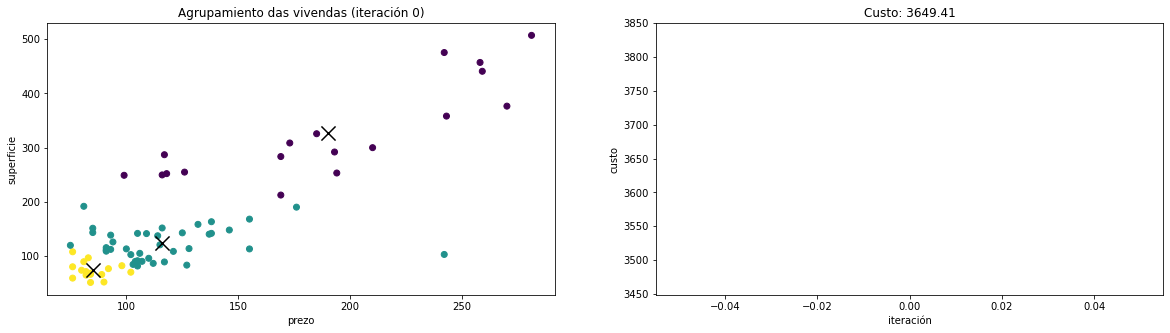

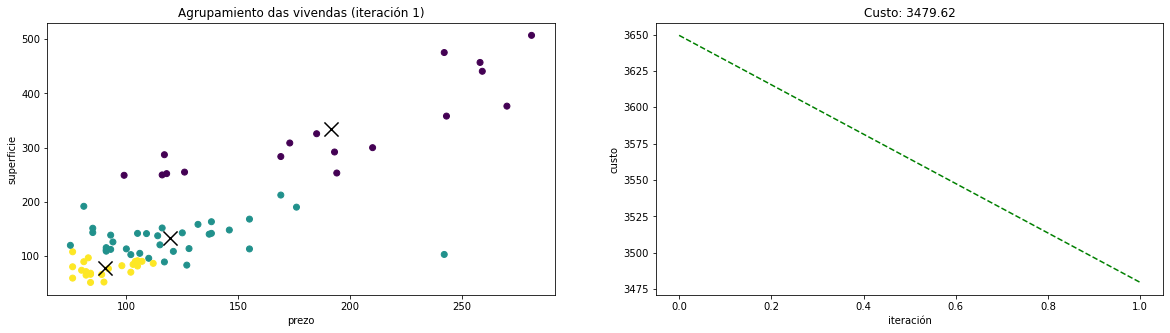

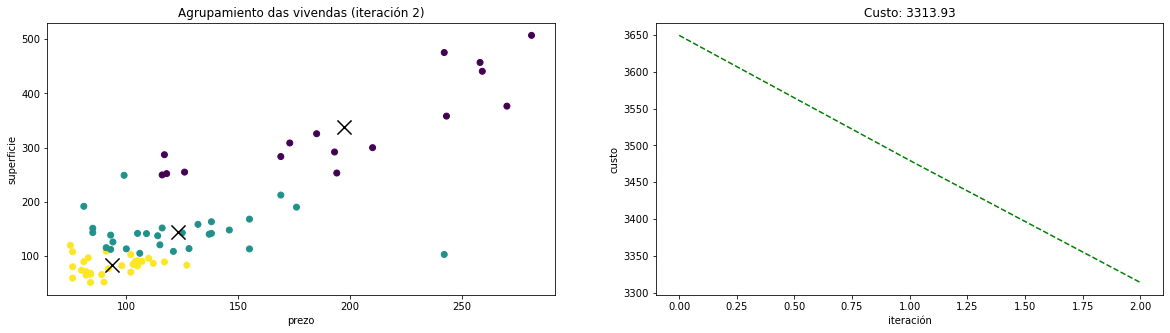

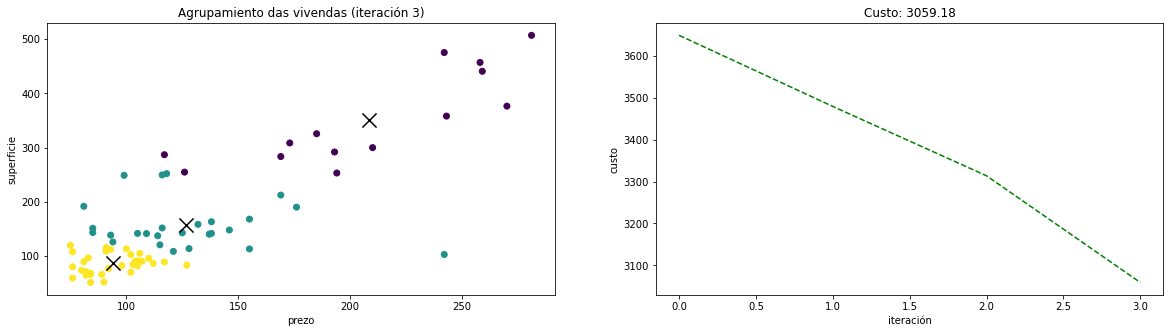

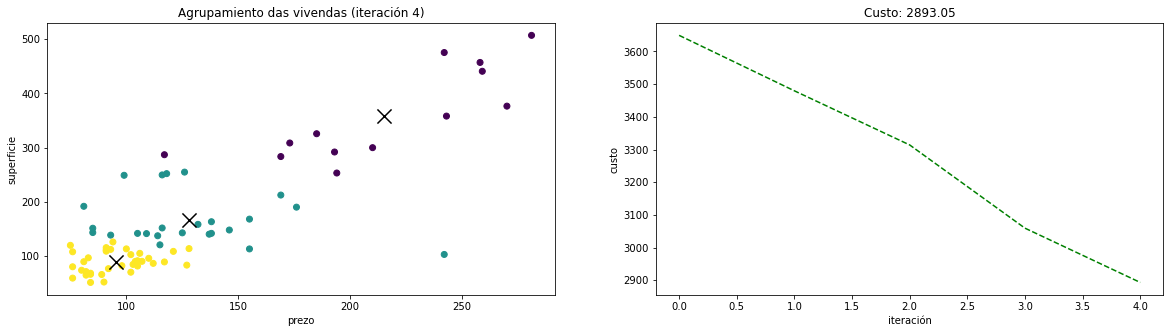

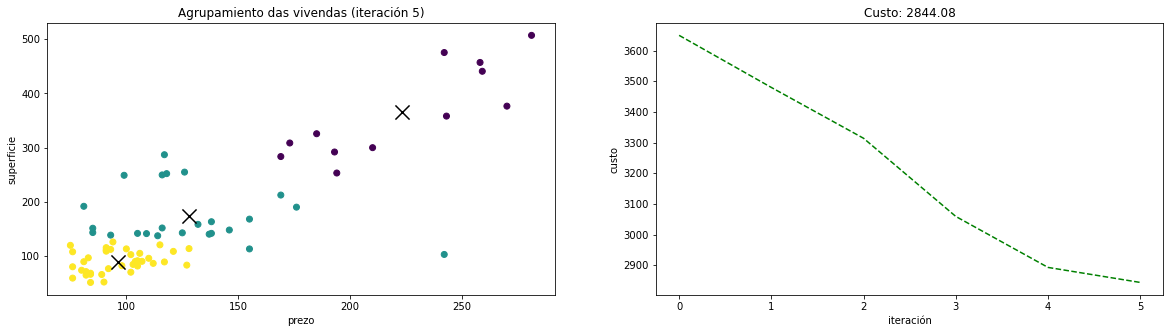

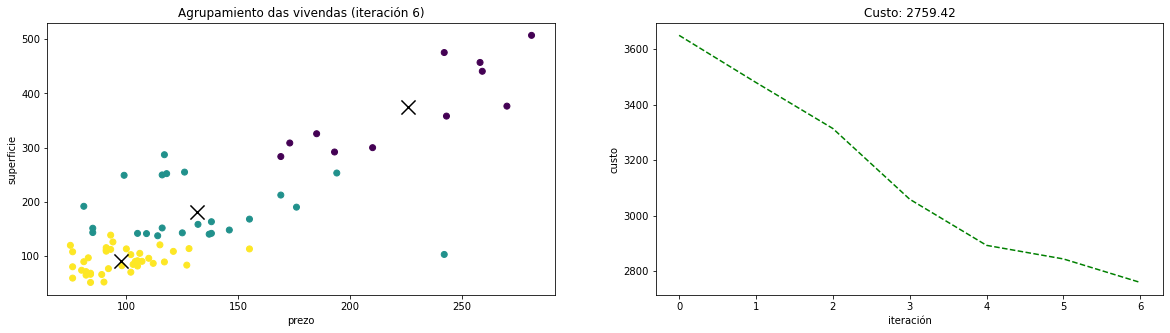

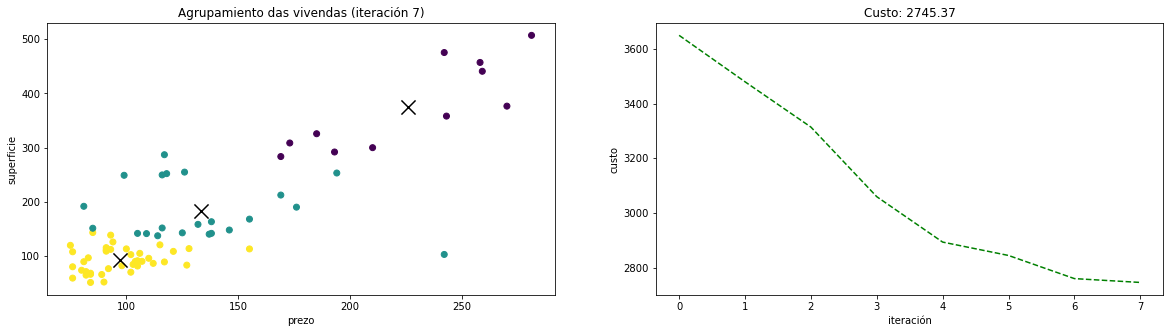

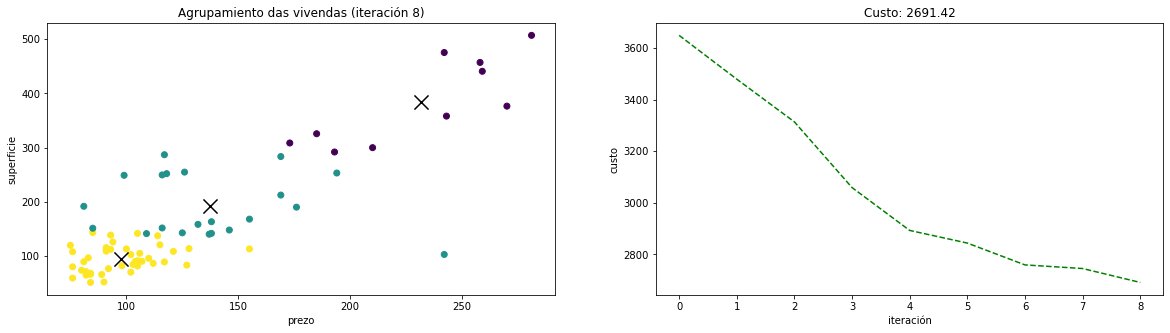

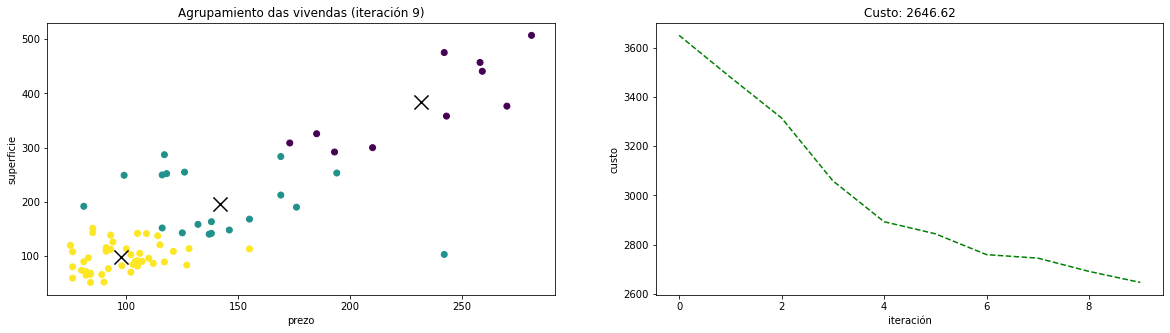

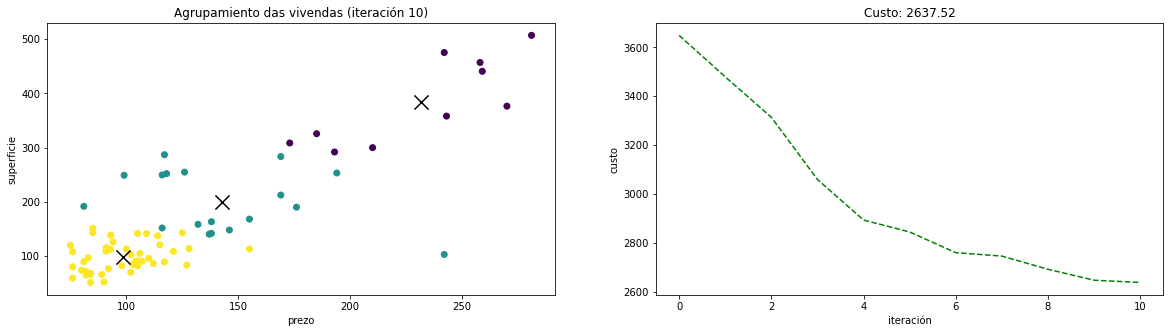

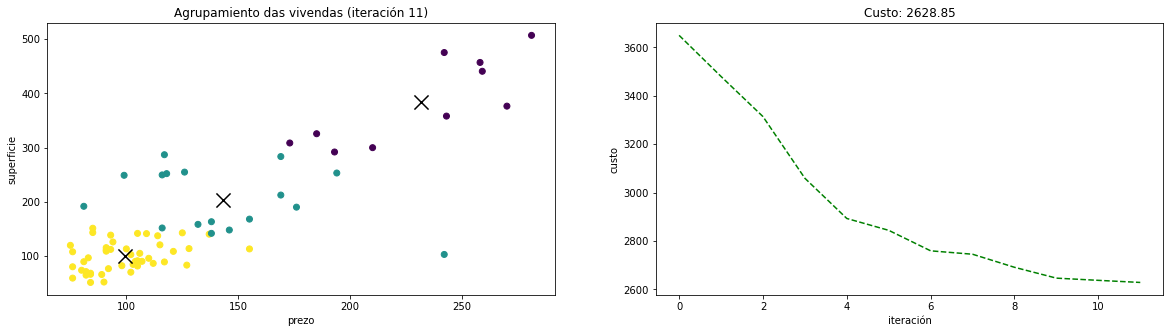

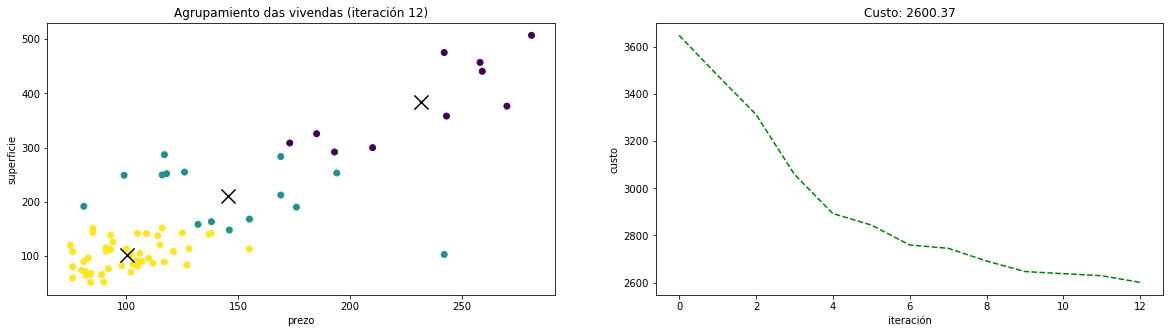

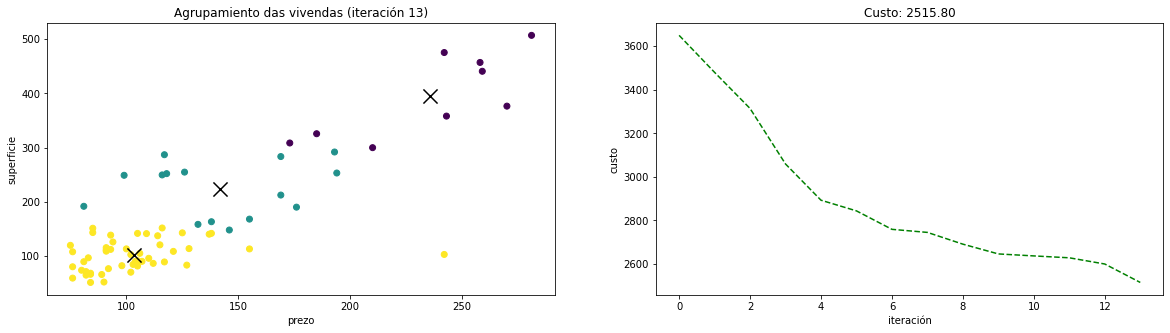

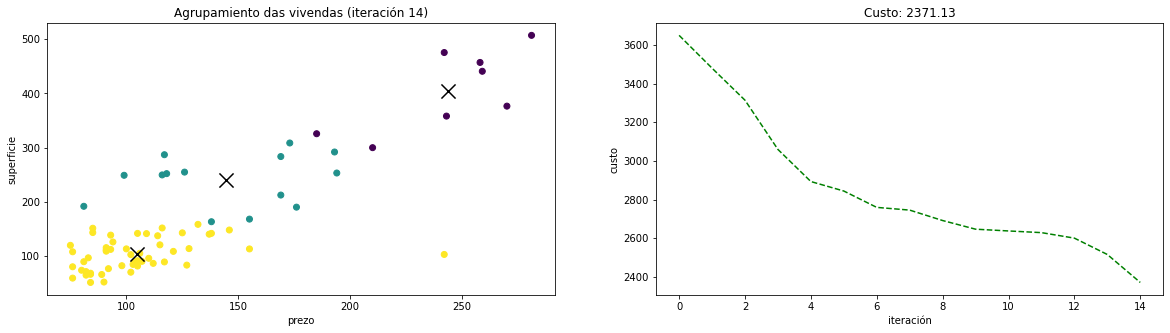

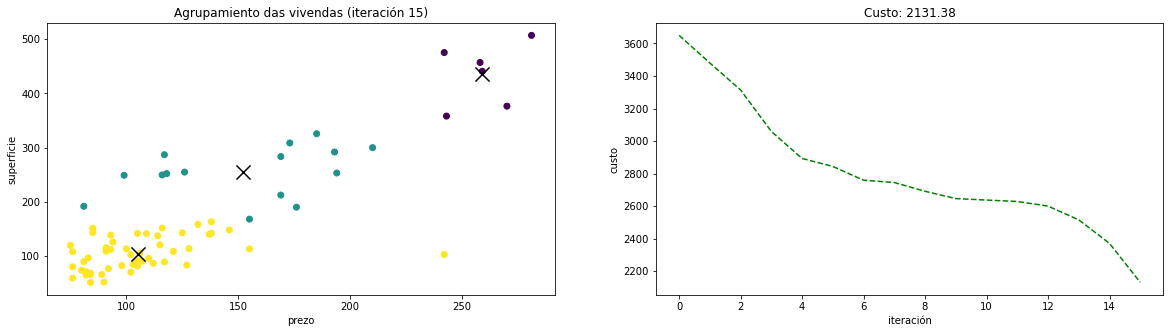

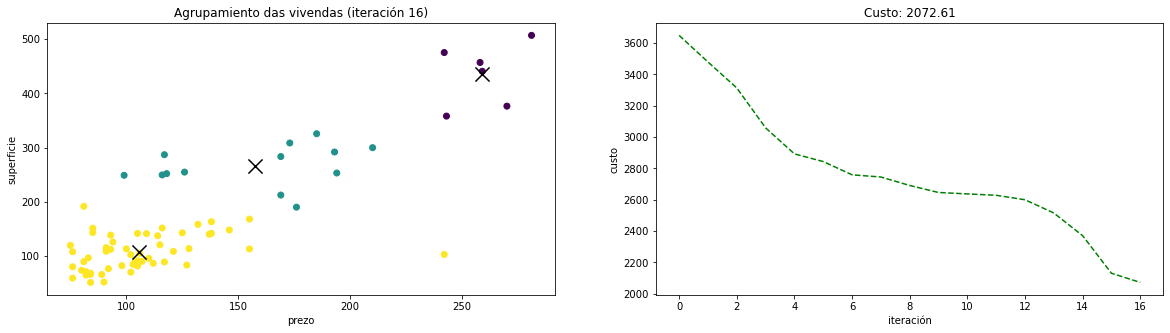

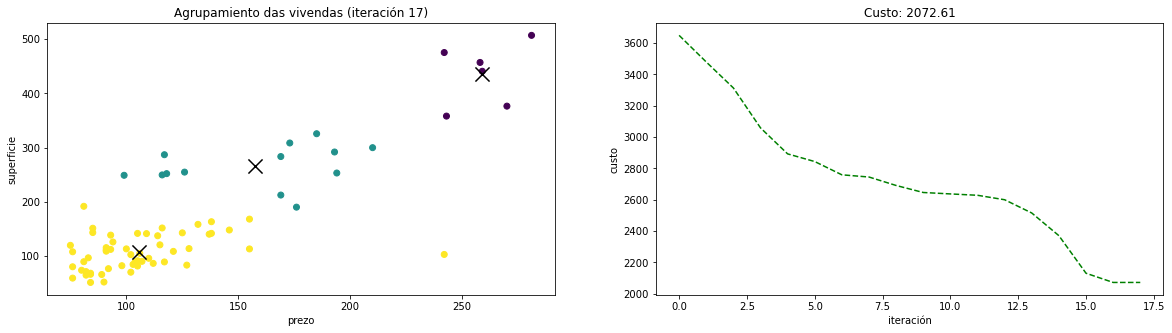

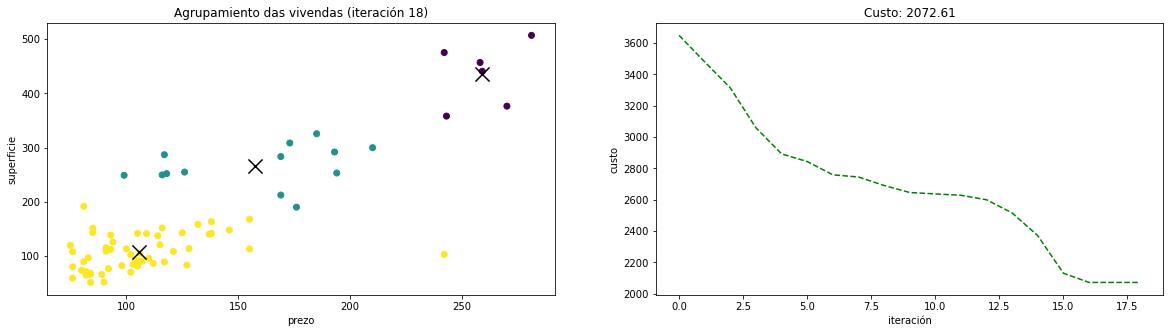

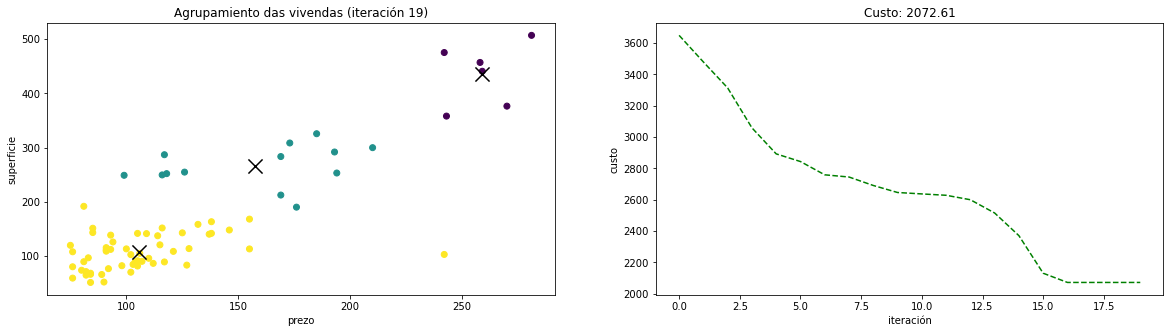

In [62]:
import matplotlib.pyplot as plt

for i in range(n_iter):
    fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
    ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])
    ax2 = fig.add_subplot(122, projection='rectilinear')
    
    # Engadimos os scatterplots
    ax1.scatter(vivendas['superficie'], vivendas['prezo'], c=agrupamento_1['clusters'][i])  #Vivendas
    ax1.scatter(agrupamento_1['centroides'][i][:, 0], agrupamento_1['centroides'][i][:, 1],
                s=200, marker='x', color='black')  # Centroides
    ax1.set_title("Agrupamiento das vivendas (iteración {})".format(i))  # Poñemos un título
    ax1.set_xlabel("prezo")  # Nombramos os eixos
    ax1.set_ylabel("superficie")
    
    # Engadimos os custos
    ax2.plot(range(i+1), agrupamento_1['custo'][:i+1], '--', color="green")
    ax2.set_title("Custo: {:.2f}".format(agrupamento_1['custo'][i]))  # Poñemos un título
    ax2.set_xlabel("iteración")  # Nombramos os eixos
    ax2.set_ylabel("custo")


    plt.show()  # Mostramos a figura por pantalla

Nas figuras anteriores, a gráfica da esquerda indica sempre o agrupamento realizado. Os exemplos do conxunto de datos coloréanse de distinta cor en función do cluster ao que son asignados. As **x** cunha circunferencia arredor ubican os centroides. Na gráfica da dereita temos a evolución do custo ($J$) nas sucesivas iteracións, tal e como faciamos en regresión lineal.

Agora que viches o proceso de clustering paso a paso, trata de responder ás seguintes cuestións.

> ❓ **_Pregunta 1._**  Lembra que na práctica anterior o custo viña dado polo erro cadrático medio das diferenzas entre cada predición e o valor do prezo real. Como estimamos o custo no caso da aprendizaxe non supervisada con k-means?

> ❓ **_Pregunta 2._**  Explica que é a saída da función `calcula_distancias`.

> ❓ **_Pregunta 3._**  Explica que contén `x_cluster_i` e que é o que fai a expresión `np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]` na función `actualiza_centr`.

> ❓ **_Pregunta 4._**  Identifica no código dos scripts anteriores onde se realizan cada unha das 3 etapas de k-means (inicialización, asignación dos datos aos clusters e actualización dos centroides).

### Inicialización aleatoria múltiple dos centroides

Se cambiamos os centroides iniciais, o algoritmo pode non converxer aos mesmos resultados.

In [63]:
SEED_VALUE = 22634  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados

np.random.seed(SEED_VALUE)
centr_iniciais_2 = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]
centr_iniciais_2

array([[259.  , 440.83],
       [ 81.  ,  89.52],
       [126.  , 254.81]])

In [64]:
# Realizamos un novo agrupamento
agrupamento_2 = k_medias(vivendas_mat, centr_iniciais_2, n_iter)

Neste caso, posto que o problema é pequeno e sinxelo, 20 iteracións son máis que suficientes para converxer ao agrupamento óptimo, sexan cales sexan os centroides de arranque:

In [65]:
# Centroides finais do primeiro agrupamento
agrupamento_1['centroides'][n_iter-1]

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [66]:
# Centroides finais do segundo agrupamento
agrupamento_2['centroides'][n_iter-1]

array([[258.83333333, 435.845     ],
       [105.77777778, 107.42740741],
       [157.30769231, 265.95846154]])

Fíxate que, aínda que en esencia os resultados son os mesmos que no primeiro agrupamento, os centroides 2 e 3 están intercambiados, polo que tecnicamente a solución á que chega o algoritmo é outra (e, porén, todo o proceso iterativo foi distinto).

En moitos problemas reais os resultados cambiarán moito en función de como inicialicemos os centroides. Incluso no problema das vivendas, se o número de iteracións é máis pequeno (por exemplo, 10), non sempre se acadará o óptimo global. Porén sóense realizar múltiples ($m$) inicializacións aleatorias dos centroides. A seguinte función é unha extensión da función base `k_medias` que permite executar o k-means para $m$ inicializacións distintas dos centroides e un valor $k$ constante:

In [67]:
# Función k-means de inicialización aleatoria múltipe
def k_medias_multi_ini(x, n, m, k):
    x_mat = x.values
    custos_finais = []
    centroides_finais = []
    clusters_finais = []
    for i in range(m):
        centr_iniciais = x_mat[np.random.choice(x_mat.shape[0], size=k, replace=False)]
        agrupamento = k_medias(x_mat, centr_iniciais, n)
        custos_finais.append(agrupamento['custo'][n-1])
        centroides_finais.append(agrupamento['centroides'][n-1])
        clusters_finais.append(agrupamento['clusters'][n-1])
    
    custo_minimo = min(custos_finais)
    indice_mellor = np.argmin(custos_finais)
    centroides_mellor = centroides_finais[indice_mellor]
    clusters_mellor = clusters_finais[indice_mellor]
    
    return {'custo_minimo': custo_minimo, 'mellor_iteracion': indice_mellor,
            'mellores_centroides': centroides_mellor, 'mellor_asignacion': clusters_mellor}

Imos probar a función anterior:

In [68]:
SEED_VALUE = 134  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)

m_ini = 10
n_iter = 15
k_cent = 3
agrupamento_3 = k_medias_multi_ini(x=vivendas, n=n_iter, m=m_ini, k=k_cent)

In [69]:
# Mellor iteración
agrupamento_3['mellor_iteracion']

5

In [70]:
# Mellores centroides
agrupamento_3['mellores_centroides']

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [71]:
# Asignación do mellor cluster para cada un dos 6 primeiros exemplos do dataset:
agrupamento_3['mellor_asignacion'][:6]

array([2, 1, 1, 2, 1, 2])

> ❓ **_Pregunta 5._**  Que devolve a saída da función `k_medias_multi_ini`? Como se elixen os mellores centroides?

### Selección do número de centroides

Polo de agora mantivemos o valor de $k$ constante, facendo sempre agrupamentos en 3 clusters. Unha pregunta que che podería xurdir a estas alturas é como saber cal é o número de centroides máis axeitado. A selección do $k$ óptimo é a miúdo ambigua, con interpretacións que dependen da forma e a escala da distribución de puntos no conxunto de datos. Aumentar o $k$ sen penalización sempre reducirá o valor do custo na agrupación resultante, ata o caso extremo de custo cero se cada punto dos datos se considera como o seu propio agrupamento (é decir, cando $k$ é igual ao número de exemplos do conxunto de datos). Intuitivamente, a elección óptima de $k$ acadará un equilibrio entre a compresión máxima dos datos utilizando un só cluster e a máxima precisión ao asignar cada instancia ao seu cluster propio. 

Cando o valor apropiado de $k$ non é evidente a partir do coñecemento previo das propiedades do conxunto de datos, existen métodos que nos axudan a tomar esta decisión. Un dos máis sinxelos é o **método do cóbado** (en inglés, *elbow method*), o cal analiza a redución do custo en función do número de clusters: debe elixirse aquel número de clusters tal que, ao agregar outro cluster máis non se acaden resultados moito mellores. Dun xeito máis formal, se se grafica o custo obtido en función de $k$, os primeiros agrupamentos terán un alto erro por agrupar moitos datos en poucos clusters, pero nalgún momento a ganancia marxinal caerá, provocando un "cóbado" no gráfico. O número de clusters fíxase a este punto, de ahí o nome do método. 

O seguinte script executa o método `k_medias_multi_ini` para distintos valores de $k$ (o mínimo é $k=2$):

In [72]:
SEED_VALUE = 42  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)

k_max = 10
m_ini = 10
n_iter = 20
custos_finais = []
centroides_finais = []
clusters_finais = []
for k in range(2, k_max+1):
    print(k)
    agrupamento = k_medias_multi_ini(x=vivendas, n=n_iter, m=m_ini, k=k)
    custos_finais.append(agrupamento['custo_minimo'])
    centroides_finais.append(agrupamento['mellores_centroides'])
    clusters_finais.append(agrupamento['mellor_asignacion'])

2
3
4
5
6
7
8
9
10


> ❓ **_Pregunta 6._**  Cantas veces se executa o algoritmo k-means no script anterior?

Agora imos aplicar o método do cóbado para determinar o número óptimo de clusters. Para iso, graficamos a evolución do custo en función de $k$:

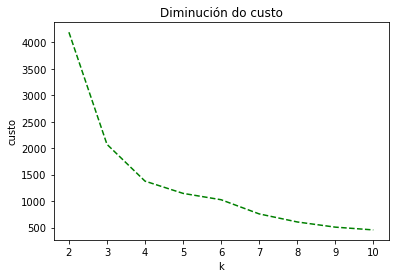

In [73]:
plt.plot(range(2, k_max+1), custos_finais, '--', color="green")
plt.title("Diminución do custo") 
plt.xlabel("k")
plt.ylabel("custo")
plt.show()

A simple vista pódese apreciar que o "cóbado" da función está en $k=4$. A partir deste valor a mellora que obtemos é moito menos significativa. Por tanto podemos asumir que o número de clusters ideal é 4:

In [74]:
k_mellor = 4

# Centroides para o mellor k (4)
centroides_mellor = centroides_finais[k_mellor-2]  # Hai que ter en conta que a lista comeza en 2
centroides_mellor

array([[128.75      , 145.0095    ],
       [ 94.65714286,  88.31571429],
       [155.75      , 272.275     ],
       [258.83333333, 435.845     ]])

In [75]:
# Asignación do mellor cluster para cada un dos 6 primeiros exemplos do dataset
clusters_mellor = clusters_finais[k_mellor-2]  # Hai que ter en conta que a lista comeza en 2
clusters_mellor[:6]

array([0, 2, 2, 0, 2, 1])

Graficamos o último agrupamento, que imos considerar o definitivo:

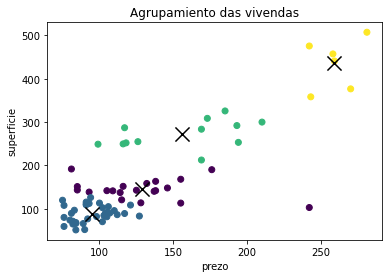

In [76]:
fig = plt.figure()  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(111, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo)

# Engadimos os scatterplots
ax1.scatter(vivendas['superficie'], vivendas['prezo'], c=clusters_mellor)  #Vivendas
ax1.scatter(centroides_mellor[:, 0], centroides_mellor[:, 1], s=200, marker='x', color='black')  # Centroides

ax1.set_title("Agrupamiento das vivendas")  # Poñemos un título
ax1.set_xlabel("prezo")  # Nombramos os eixos
ax1.set_ylabel("superficie")

plt.show()  # Mostramos a figura por pantalla

### Interpretación dos resultados

Quedaría agora unha última etapa de análise e interpretación dos resultados. Haberá situacións (coma esta) onde a interpretación sexa bastante trivial. Sen embargo, en moitos problemas reais onde se traballa cun maior número de variables (porén, xa non estamos falando de interpretar un simple gráfico 2D) pode resultar moi complexo lograr atribuírlle un significado aos grupos formados.

> ❓ **_Pregunta 7._**  Fai unha breve interpretación dos clusters obtidos.

## Agrupamento coa función `KMeans`

Unha vez máis, `scikit-learn` facilítanos as tarefas de clustering proporcionándonos paquetes e funcións moi útiles. Unha das funcións imprescindibles é `KMeans`. No seguinte script imos volver a obter o primeiro dos agrupamentos que realizamos no exercicio anterior, pero invocando a `KMeans` en lugar de `k_medias`:

In [77]:
from sklearn.cluster import KMeans

# Definimos o número de iteracións
n_iter <- 20

# Obtemos os mesmos centroides iniciais que antes
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)
centr_iniciais = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]

# Definimos o modelo
model = KMeans(n_clusters=len(centr_iniciais), init=centr_iniciais, n_init=1,
               max_iter=n_iter, algorithm='full', random_state=SEED_VALUE)

# Axustamos o modelo aos datos
np.random.seed(SEED_VALUE)
agrupamento_4 = model.fit(vivendas)

O argumento `algorithm="full"` simplemente nos asegura que por debaixo estamos empregando o mesmo método que o que implementamos no exercicio anterior (hai varias implementacións, podes consultalas na axuda de `scikit-learn`). Vemos que os centroides que obtemos con `KMeans` son os mesmos que obtiñamos antes coa nosa implementación propia:

In [78]:
# Centroides da implementación propia
agrupamento_1['centroides'][-1]

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [79]:
# Centroides obtidos coa función KMeans
agrupamento_4.cluster_centers_

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

Bótalle un ollo aos atributos que contén a clase `KMeans`. Observa que entre todos os datos de saída non se inclúe directamente o custo da función $J$ coa que estivemos traballando. Inclúese a suma de todas as distancias, sen facer a media:

In [80]:
# Custo final coa implementación propia
agrupamento_1['custo'][-1]

2072.6093651192277

In [81]:
# Custo final coa función KMeans
agrupamento_4.inertia_ / len(vivendas)

2072.6093651192286

Tamén podemos facer o cálculo manualmente, usando a función $J$ que temos definida:

In [82]:
j(x=vivendas_mat, centroides=agrupamento_4.cluster_centers_, clusters=agrupamento_4.labels_)

2072.6093651192286

**************************************************************

# Respostas ao cuestionario (4 puntos)

**LEMBRA:** Non esquezas de escribir teu nome e apelidos na segunda celda do presente documento.

**Pregunta 1: Lembra que na práctica anterior o custo viña dado polo erro cadrático medio das diferenzas entre cada predición e o valor do prezo real. Como estimamos o custo no caso da aprendizaxe non supervisada con k-means?**

O custo no caso da aprendizaxe non supervisada con k-means tamén ven dado polo erro pero este calculase de diferente maneira. Obténse a través da suma das distancias cuadráticas de cada centroide respecto aos seus puntos. Estos valores minimizanse en cada iteración, é dicir, o obxectivo si que segue sendo o mesmo.

**Pregunta 2: Explica que é a saída da función calcula_distancias.**

Antes de explicar a saída, procedemos a explicar o funcionamento da propia función. Primeramente, recibe dous argumentos:
   1. O argumento "a" é a lista de todos os puntos da gráfica 
   2. O argumento "b" é a lista de centroides da gráfica.
    
Con estos argumentos, fai o seguinte:
1. Defínese unha matriz de distancias vacía. Nesta matriz, unha posición (a, b) representa a distancia entre o punto a e o centroide b. 
2. Faise unha iteración na lista de puntos recorrendo cada un deles.                                                           
    2.1  Para cada punto, calculase a distancia cos centroides.    
    2.2  Todo esta información vaise gardando na matriz distancia.
3. A función devolve a matriz coa distancia entre cada punto e o centroide

Como conclusión, a saída da función "calcula_distancias" é a matriz con todas as distancias.

**Pregunta 3: Explica que contén x_cluster_i e que é o que fai a expresión np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0] na función actualiza_centr.**

Na función actualiza_centr:

    -"x_cluster_i" conten os puntos "x" os cales "cluster" é igual ao contador "i"
    -A expresión "np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]" actualiza a posición do centroide i á posición media dos puntos que teña asignado ese centroide.


**Pregunta 4:  Identifica no código dos scripts anteriores onde se realizan cada unha das 3 etapas de k-means (inicialización, asignación dos datos aos clusters e actualización dos centroides).**

As tres etapas de k-means:
1. Inicialización: Realízase antes da función k_medias(x, centroides, iteracions). Na liña centr_iniciais=vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]. Aquí, escóllese as posicións dos centroides iniciais.
2. Asignación dos datos aos cluster: Isto faise na función calcula_distancias. Asignase a cada centroide un punto do dataset e calcúlase a distancia de cada punto co centroide. Finalmente, elíxese para cada punto un cluster no "np.argmin"
3. Actualización dos centroides: Isto faise na función actualiza_centr.

In [32]:
import numpy as np

# Función de distancia cadrática
def calcula_distancias(a, b):
    matriz_distancias = np.empty([a.shape[0], b.shape[0]]) #matriz con numero de filas con los puntos de a y con el nº de puntos de b
    # Calculamos a distancia punto a punto dos conxuntos a e b
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            dist = a[i] - b[j]
            matriz_distancias[i, j] = dist[0] ** 2 + dist[1] ** 2
    
    return matriz_distancias

# Función a optimizar J
def j(x, centroides, clusters):
    # Obtemos a distancia de cada punto ao seu cluster
    distancias = x - centroides[clusters]
    # Calculamos o custo
    custo = 1.0/x.shape[0] * sum((np.sqrt(distancias[:, 0]**2 + distancias[:,1]**2))**2)
    return custo

# Función de actualización de centroides
def actualiza_centr(x, clusters, centroides):
    for i in range(centroides.shape[0]):
        x_cluster_i = x[clusters==i]
        centroides[i] = np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]
    
    return centroides

# Función de clustering k-means
def k_medias(x, centroides, iteracions):
    hist_clusters = []
    hist_centroides = []
    hist_custo = []
    
    for i in range(iteracions):
        dist_centroides = calcula_distancias(x, centroides) #calcular distancia de cada punto con cada centroide
        clusters = np.argmin(dist_centroides, axis=1) #Returns the indices of the minimum values along an axis
        centroides = actualiza_centr(x, clusters, centroides)
        custo = j(x, centroides, clusters)
        # Gardamos o historial de cada iteración
        hist_clusters.append(clusters)
        hist_centroides.append(centroides.copy())
        hist_custo.append(custo)
    
    return {'custo': hist_custo, 'clusters': hist_clusters, 'centroides': hist_centroides}

**Pregunta 5: Que devolve a saída da función k_medias_multi_ini? Como se elixen os mellores centroides?**

A saída da función k_medias_multi_ini é un conxunto de 4 datos:
1. Custo_minimo -> Custe mínimo das distancias aos centroides
2. Indice_mellor -> Índice da mellor iteración
3. Centroides_mellor -> Posicións dos centroides da mellor iteración
4. Clusters_mellor -> Asignación dos puntos a cada cluster na mellor iteración

Para elixir os mellores centroides, faise unha iteración na que en cada execución realiza o seguinte:
1. Inicializase os centroides nunha posición aleatoria.
2. Calculase e almacenase en que posición acaban.
Finalmente, obsérvase o resultado destas distintas iteracións e escóllese o mellor resultado.

**Pregunta 6: Cantas veces se executa o algoritmo k-means no script anterior?**

Modificamos o algoritmo para que imprima a k en cada iteración. A k "máxima" é 10, é dicir, a iteración for execútase dende 2 ata 10+1 (9 iteracións).

Dentro de esta iteración, chámase a función k_medias_multi_ini:

      "agrupamento = k_medias_multi_ini(x=vivendas, n=n_iter, m=m_ini, k=k)"

Podemos observar que co parámetro "m= m_ini" executaráse 10 inicializacións diferentes dos centroides.

Finalmente, 9 iteracións x 10 inicializacións son 90 veces. O algoritmo k-means no script anterior execútase 90 veces.

**Pregunta 7: Fai unha breve interpretación dos clusters obtidos.**

Podemos interpretar os resultados obtidos a través de catro grupos:
1. Grupo 1: Vivendas cunha superficie pequena e baixo prezo.
2. Grupo 2: Vivendas cunha superficie pequena e baixo prezo (pero algo maior co grupo 1)
3. Grupo 3: Agrupación de puntos dispersos. Podemos interpretar que son casas.
4. Grupo 4: Vivendas cunha gran superfice e prezo.

**************************************************************

# Modelado dun problema de libre elección 

## Enunciado

Pon en práctica os teus coñecementos de aprendizaxe non supervisado e intenta agora ti buscar relacións entre os datos dun problema que se che ocorra. Nos exercicios anteriores abordouse o caso de 2 variables, polo que animámoste agora a que trates de aplicar clustering sobre un problema con máis dimensións. O único requerimento obrigatorio é **empregar máis de dúas variables para o clustering**. Ten en conta que a nosa implementación de k-means (`k_medias`) está pensada para funcionar sobre conxuntos de datos con dúas variables, pero non é escalable a máis dimensións (certo é que as modificacións necesarias para logralo son mínimas). A vantaxe da función `KMeans` propia de `scikit-learn` é a súa flexibilidade, pois o seu parámetro `x` pode tomar como entrada conxuntos de datos cun maior número de variables. Ten tamén presente que ao aplicar clustering sobre un conxunto de datos de máis de 2 ou 3 variables, a súa visualización complícase e o mellor é visualizar o agrupamento por pares de variables de cara a obter unha boa interpretación.

Igual que na práctica anterior, podes recadar datos e construir un pequeno dataset ti mesmo ou ben obter un de Internet. Fai un breve estudo dos teus datos, incluíndo gráficas e comentarios propios. Obtén un bo agrupamento e da unha interpretación do mesmo. Proporciona todo o código que consideres necesario empregando scripts como os dos exercicios anteriores. Ao entregar esta práctica deberás incluir tamén o arquivo cos datos do teu problema no formato que che resulte máis cómodo (.csv, .txt, etc.).

**************************************************************

## Resposta (6 puntos)

In [83]:
# INTRODUCE O TEU CÓDIGO AQUÍ (tamén podes usar celdas Markdown para as explicacións)
SEED_VALUE = 190463 
import seaborn as sns 
from sklearn.cluster import KMeans

### Comenzaremos importando o dataset que vamos a utilizar e elixindo as columnas que queremos utilizar. 

### O dataset elexido é o menu completo de bebidas da empresa Starbucks.

In [84]:
starbucks = pd.read_csv('starbucks.csv',  delimiter=',',header=0)
starbucks.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Beverage_category       242 non-null    object 
 1   Beverage                242 non-null    object 
 2   Beverage_prep           242 non-null    object 
 3   Calories                242 non-null    int64  
 4   Total Fat(g)            242 non-null    float64
 5   Trans Fat               242 non-null    float64
 6   Saturated Fat           242 non-null    float64
 7    Sodium(mg)             242 non-null    int64  
 8   Total Carbohydrates(g)  242 non-null    int64  
 9   Cholesterol(mg)         242 non-null    int64  
 10  Dietary Fibre           242 non-null    int64  
 11  Sugars(g)               242 non-null    int64  
 12  Protein(g)              242 non-null    float64
 13  Vitamin A (% DV)        242 non-null    object 
 14  Vitamin C (% DV)        242 non-null    ob

### Mostramos as 10 primeiras filas do dataset

In [85]:
starbucks.head(10)

,Beverage_category,Beverage,Beverage_prep,Calories,Total Fat(g),Trans Fat,Saturated Fat,Sodium(mg),Total Carbohydrates(g),Cholesterol(mg),Dietary Fibre,Sugars(g),Protein(g),Vitamin A (% DV),Vitamin C (% DV),Calcium (% DV),Iron (% DV),Caffeine (mg)
0,Coffee,Brewed Coffee,Short,3,0.1,0.0,0.0,0,5,0,0,0,0.3,0%,0%,0%,0%,175
1,Coffee,Brewed Coffee,Tall,4,0.1,0.0,0.0,0,10,0,0,0,0.5,0%,0%,0%,0%,260
2,Coffee,Brewed Coffee,Grande,5,0.1,0.0,0.0,0,10,0,0,0,1.0,0%,0%,0%,0%,330
3,Coffee,Brewed Coffee,Venti,5,0.1,0.0,0.0,0,10,0,0,0,1.0,0%,0%,2%,0%,410
4,Classic Espresso Drinks,Caffè Latte,Short Nonfat Milk,70,0.1,0.1,0.0,5,75,10,0,9,6.0,10%,0%,20%,0%,75
5,Classic Espresso Drinks,Caffè Latte,2% Milk,100,3.5,2.0,0.1,15,85,10,0,9,6.0,10%,0%,20%,0%,75
6,Classic Espresso Drinks,Caffè Latte,Soymilk,70,2.5,0.4,0.0,0,65,6,1,4,5.0,6%,0%,20%,8%,75
7,Classic Espresso Drinks,Caffè Latte,Tall Nonfat Milk,100,0.2,0.2,0.0,5,120,15,0,14,10.0,15%,0%,30%,0%,75
8,Classic Espresso Drinks,Caffè Latte,2% Milk,150,6.0,3.0,0.2,25,135,15,0,14,10.0,15%,0%,30%,0%,75
9,Classic Espresso Drinks,Caffè Latte,Soymilk,110,4.5,0.5,0.0,0,105,10,1,6,8.0,10%,0%,30%,15%,75


### Escollemos un número de columnas decente de manexar e normalizamos o conxunto de datos.  

### A normalización é necesario pois como podemos ver na celda anterior, hai unha gran cantidade de datos diferentes. Aplicamos un rango entre 0 e 20.

In [86]:
starbucksSmall = starbucks[["Calories", "Total Fat(g)", "Total Carbohydrates(g)", "Sugars(g)", "Protein(g)"]]

In [87]:
starbucksSmall=((starbucksSmall-starbucksSmall.min())/(starbucksSmall.max()-starbucksSmall.min()))*20
starbucksSmall.head(10)

,Calories,Total Fat(g),Total Carbohydrates(g),Sugars(g),Protein(g)
0,0.117647,0.133333,0.294118,0.000000,0.3
1,0.156863,0.133333,0.588235,0.000000,0.5
2,0.196078,0.133333,0.588235,0.000000,1.0
3,0.196078,0.133333,0.588235,0.000000,1.0
4,2.745098,0.133333,4.411765,2.142857,6.0
5,3.921569,4.666667,5.000000,2.142857,6.0
6,2.745098,3.333333,3.823529,0.952381,5.0
7,3.921569,0.266667,7.058824,3.333333,10.0
8,5.882353,8.000000,7.941176,3.333333,10.0
9,4.313725,6.000000,6.176471,1.428571,8.0


### Tras definir descartar e normalizar as columnas que queremos, visualizaremos estas variables para empezar a buscar un bó número de clusters para conseguir uns resultados óptimos. 

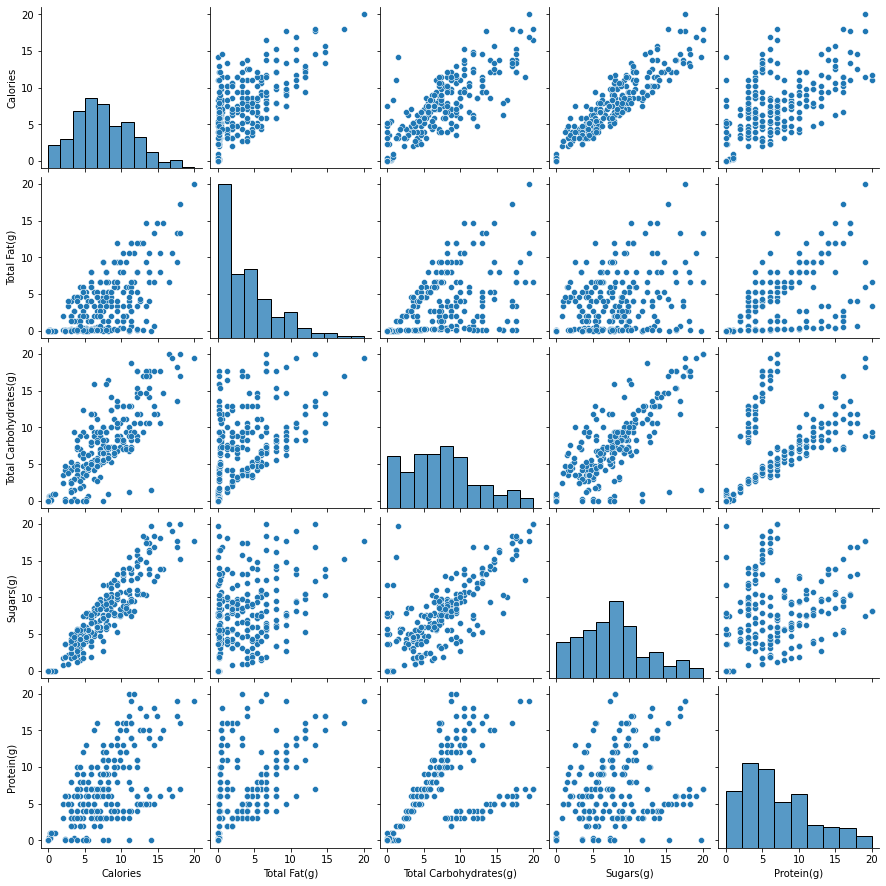

In [88]:
visualizacion = sns.pairplot(starbucksSmall)
visualizacion

Gráfica:


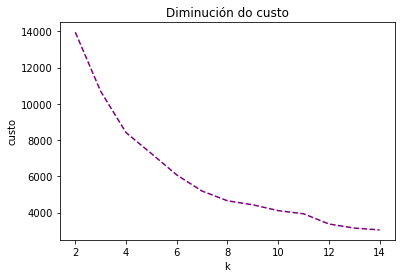

Tuple:


(47, 192, 24, 178, 85)

In [89]:
cMAX = 15 #Número de clusters máximo
i = 20 #Número de iteracións máximas
mMATRIZ = starbucksSmall.values #Matriz do dataset
MatrizCostes = [] #Matriz para gardar os costes de cada resultado

for k in range(2, cMAX):      
    #Definimos o modelo
    model = KMeans(n_clusters=k, n_init=1, max_iter=i, algorithm='full', random_state=SEED_VALUE)
    #Axustamos o modelo aos datos
    np.random.seed(SEED_VALUE)
    agrupamento = model.fit(mMATRIZ)
    #Insertamos o coste dentro da lista de costes
    MatrizCostes.append(model.inertia_)
    
print("Gráfica:")
plt.plot(range(2, cMAX), MatrizCostes, '--', color="purple")
plt.title("Diminución do custo") 
plt.xlabel("k")
plt.ylabel("custo")
#Creamos unha gráfica:
    #eje x -> numero de clusters
    #eje y -> coste
plt.show()

print("Tuple:")
tuple(np.random.choice(mMATRIZ.shape[0], size=5, replace=False))  

### Creamos o modelo K-Means, predecimos o cluster de cada punto na matriz e engadimos unha nova columa que representa o número de clusters óptimo.

In [90]:
model = KMeans(n_clusters=5 , n_init=1, max_iter=i, algorithm='full', random_state=SEED_VALUE)
predicions = model.fit_predict(mMATRIZ) 
starbucksSmall["ClusterOptimos"] = predicions
starbucksSmall.head(20)

,Calories,Total Fat(g),Total Carbohydrates(g),Sugars(g),Protein(g),ClusterOptimos
0,0.117647,0.133333,0.294118,0.000000,0.3,3
1,0.156863,0.133333,0.588235,0.000000,0.5,3
2,0.196078,0.133333,0.588235,0.000000,1.0,3
3,0.196078,0.133333,0.588235,0.000000,1.0,3
4,2.745098,0.133333,4.411765,2.142857,6.0,3
5,3.921569,4.666667,5.000000,2.142857,6.0,0
6,2.745098,3.333333,3.823529,0.952381,5.0,3
7,3.921569,0.266667,7.058824,3.333333,10.0,0
8,5.882353,8.000000,7.941176,3.333333,10.0,0
9,4.313725,6.000000,6.176471,1.428571,8.0,0


### Mostramos as gráficas do novo dataset. Cada grupo ten unha cor diferente.    

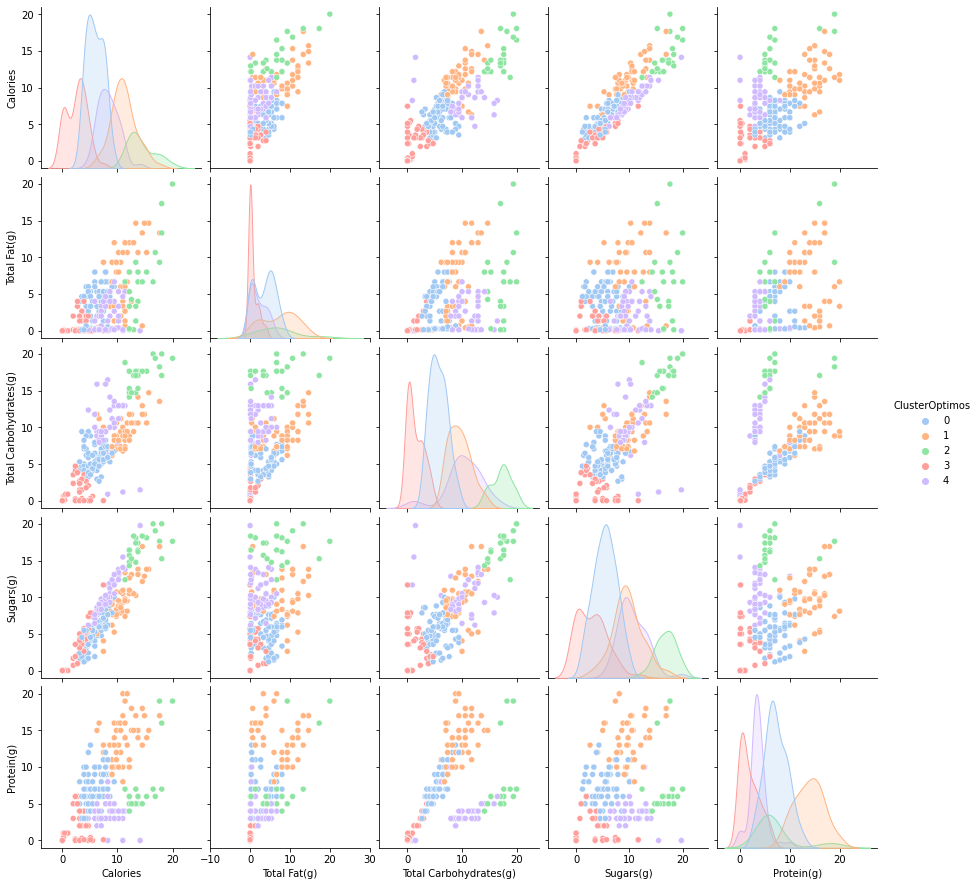

In [91]:
visualizacion = sns.pairplot(starbucksSmall, hue="ClusterOptimos", palette="pastel")
visualizacion 

### O dataset dividise en 5 grupos diferentes: 0,1,2,3,4 . Todos estes grupos comparten unhas caraterísticas parecidas.
### 1. Grupo rojo (3).
### 2. Grupo violeta (4).
### 3. Grupo azul (0).
### 4. Grupo verde (2).
### 5. Grupo naranja (1).

### Visualmente de primeiras, podemos observar que o grupo rojo (3) sempre encontrase nas posicións (x,y) máis baixas. Este grupo podria representar as bebidas menos calóricas (máis saludables). Mencionar que tamén poder existir algun dato neste conxunto que sexan vasos pequenos de bebida pero bastante calóricas. 

### Por outro lado, o grupo naranja(1) e grupo verde(2) sempre discuten por ocupar as posicións (x,y) máis altas. Este grupo podría representar o contrario ao grupo rojo: as bebidas mais calóricas ( menos saludables)

### Vamos a intentar analizarlo máis detenidamente imprimindo os nomes das bebidas que pertencen a cada grupo:

In [92]:
nomes = starbucks["Beverage"] + " " +  starbucks["Beverage_prep"]
starbucksSmall["Nome"] = nomes

In [93]:
print(starbucksSmall[starbucksSmall["ClusterOptimos"] == 4]["Nome"].head(20))

99      Caramel Apple Spice (Without Whipped Cream) Tall
100    Caramel Apple Spice (Without Whipped Cream) Gr...
101    Caramel Apple Spice (Without Whipped Cream) Venti
112              Tazo® Chai Tea Latte Grande Nonfat Milk
115               Tazo® Chai Tea Latte Venti Nonfat Milk
181                              Coffee Tall Nonfat Milk
182                                    Coffee Whole Milk
183                                       Coffee Soymilk
184                            Coffee Grande Nonfat Milk
185                                    Coffee Whole Milk
186                                       Coffee Soymilk
190       Mocha (Without Whipped Cream) Tall Nonfat Milk
191             Mocha (Without Whipped Cream) Whole Milk
192                Mocha (Without Whipped Cream) Soymilk
193     Mocha (Without Whipped Cream) Grande Nonfat Milk
194             Mocha (Without Whipped Cream) Whole Milk
195                Mocha (Without Whipped Cream) Soymilk
199     Caramel (Without Whippe

In [94]:
print(starbucksSmall[starbucksSmall["ClusterOptimos"] == 3]["Nome"].head(20))

0                                    Brewed Coffee Short
1                                     Brewed Coffee Tall
2                                   Brewed Coffee Grande
3                                    Brewed Coffee Venti
4                          Caffè Latte Short Nonfat Milk
6                                    Caffè Latte Soymilk
40                                 Caffè Americano Short
41                                  Caffè Americano Tall
42                                Caffè Americano Grande
43                                 Caffè Americano Venti
44                          Cappuccino Short Nonfat Milk
46                                    Cappuccino Soymilk
47                           Cappuccino Tall Nonfat Milk
49                                    Cappuccino Soymilk
56                                         Espresso Solo
57                                       Espresso Doppio
58          Skinny Latte (Any Flavour) Short Nonfat Milk
64                             

In [95]:
print(starbucksSmall[starbucksSmall["ClusterOptimos"] == 2]["Nome"].head(20))

83     White Chocolate Mocha (Without Whipped Cream) ...
84     White Chocolate Mocha (Without Whipped Cream) ...
85     White Chocolate Mocha (Without Whipped Cream) ...
187                             Coffee Venti Nonfat Milk
188                                    Coffee Whole Milk
189                                       Coffee Soymilk
196      Mocha (Without Whipped Cream) Venti Nonfat Milk
197             Mocha (Without Whipped Cream) Whole Milk
198                Mocha (Without Whipped Cream) Soymilk
205    Caramel (Without Whipped Cream) Venti Nonfat Milk
206           Caramel (Without Whipped Cream) Whole Milk
207              Caramel (Without Whipped Cream) Soymilk
211    Java Chip (Without Whipped Cream) Grande Nonfa...
212         Java Chip (Without Whipped Cream) Whole Milk
213            Java Chip (Without Whipped Cream) Soymilk
214    Java Chip (Without Whipped Cream) Venti Nonfat...
215         Java Chip (Without Whipped Cream) Whole Milk
216            Java Chip (Witho

In [96]:
print(starbucksSmall[starbucksSmall["ClusterOptimos"] == 1]["Nome"].head(20))

11                                  Caffè Latte 2% Milk
13                        Caffè Latte Venti Nonfat Milk
14                                  Caffè Latte 2% Milk
15                                  Caffè Latte Soymilk
22    Caffè Mocha (Without Whipped Cream) Grande Non...
23          Caffè Mocha (Without Whipped Cream) 2% Milk
24          Caffè Mocha (Without Whipped Cream) Soymilk
25    Caffè Mocha (Without Whipped Cream) Venti Nonf...
26          Caffè Mocha (Without Whipped Cream) 2% Milk
27          Caffè Mocha (Without Whipped Cream) Soymilk
35     Vanilla Latte (Or Other Flavoured Latte) 2% Milk
37    Vanilla Latte (Or Other Flavoured Latte) Venti...
38     Vanilla Latte (Or Other Flavoured Latte) 2% Milk
39     Vanilla Latte (Or Other Flavoured Latte) Soymilk
61         Skinny Latte (Any Flavour) Venti Nonfat Milk
69                            Caramel Macchiato 2% Milk
71                  Caramel Macchiato Venti Nonfat Milk
72                            Caramel Macchiato 

In [97]:
print(starbucksSmall[starbucksSmall["ClusterOptimos"] == 0]["Nome"].head(20))

5                                   Caffè Latte 2% Milk
7                          Caffè Latte Tall Nonfat Milk
8                                   Caffè Latte 2% Milk
9                                   Caffè Latte Soymilk
10                       Caffè Latte Grande Nonfat Milk
12                                  Caffè Latte Soymilk
16    Caffè Mocha (Without Whipped Cream) Short Nonf...
17          Caffè Mocha (Without Whipped Cream) 2% Milk
18          Caffè Mocha (Without Whipped Cream) Soymilk
19    Caffè Mocha (Without Whipped Cream) Tall Nonfa...
20          Caffè Mocha (Without Whipped Cream) 2% Milk
21          Caffè Mocha (Without Whipped Cream) Soymilk
28    Vanilla Latte (Or Other Flavoured Latte) Short...
29     Vanilla Latte (Or Other Flavoured Latte) 2% Milk
30     Vanilla Latte (Or Other Flavoured Latte) Soymilk
31    Vanilla Latte (Or Other Flavoured Latte) Tall ...
32     Vanilla Latte (Or Other Flavoured Latte) 2% Milk
33     Vanilla Latte (Or Other Flavoured Latte) 

### 1. Cluster 0 (azul): trátase dun grupo de bebidas baixo en calorias, azúcares, carbohidratos e grasas. Sen embargo, son alimentos bastante proteicos.  Esta representación non mostra as porcentaxes do total. Representa os datos totais. Así que visualizando a listaxe de elementos, podemos concluir que representa un grupo de bebidas saludabes (caffe latte, caffe mocha…) pero tamén bebidas menos saludables, en porcións pequeñas (podría ser cun formato de vaso pequeno) . Un exemplo podría ser Vanilla Latte.

### 2. Cluster 1 (naranja): é un conxunto de elementos bastante calórico. Presenta unhas carácteristicas elevadas en todos os aspectos: gran cantidade en proteínas, grasas, azúcares e carbohidratos. Sen embargo, na listaxe mostra un tipo de bebida moi parecido ao cluster anterior (cluster 0). Isto pode ser debido a que está formado por as bebidas menos saludables do anterior cluster pero en formatos máis grandes. Por exemplo, o Vanilla Latte do anterior cluster en este sería cunha dobre de ración de Vanilla.

### 3. Cluster 2 ( verde):  representa o tipo de cafés menos saludables de toda a carta do Starbucks. Está formado por bebidas moi calóricas, con cifras elevadas en carbohidratos e azúcares. Quitando algúns casos extraños, baixo en proteínas e grasas. Trátase de bebidas como Mocha, White Chocolate, Java Chip, Strawberries & Crème... Cafés formado con elementos moi azucarados como pode ser chocolate blanco, crema,sirope… Todo isto aumenta a cantidade de calorías.

### 4. Cluster 3 (vermello): representa o tipo de cafés máis saludables de toda a carta do Starbucks. É baixo en todos os aspectos posibles. Baixo en calorias, grasas, carbohidratas, proteinas, azúcares.... Trátase de cafés simples no que a única diferencia entre eles son a distinta porcentaxe de leite e cafeína que forma o propio café: americano, café con leite, capuccino etc...

### 5. Cluster 4 (violeta): representa un tipo de cafés bastante azúcarados pero baixos en grasas. Isto produce que teñan unha porcentaxe de calorías media. Son bastante poucos protéicos. Conteñen bastante azúcar porque son cafés con sirope de caramelo pero baixo en grasas porque está cociñado con por exemplo, froitas: Caramel Apple Spice Neste conxunto, tamén hai tés. Por iso tamén esta gran cantidade de azúcares:  Tazo® Chai Tea Latte Grande Nonfat Milk
----------------------------------------------------------------------------------------------------------------------------
### Para finalizar, vamos a calcular o coste final do modelo e os centroides finais do modelo:

In [98]:
model.inertia_ / len(starbucks)

29.9768068148645

In [99]:
model.cluster_centers_

array([[ 5.92760181,  3.55726496,  5.64102564,  5.43040293,  7.19230769],
       [11.10105581,  7.35897436,  9.53054299,  9.64285714, 13.88461538],
       [14.34937611,  6.94545455, 17.21925134, 16.80735931,  7.36363636],
       [ 2.57203751,  0.71014493,  1.47058824,  2.98654244,  1.90869565],
       [ 8.32442068,  2.08484848, 10.28743316, 10.61688312,  3.54545455]])